In [107]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision import models, transforms
import torch.nn.functional as F
import shap
import os
from PIL import Image

args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'batch_size': 64,
    # 'test_batch_size': 1000,
    'epochs': 20,
    'lr': 1e-4
}

model_urls = {"resnet34":"https://download.pytorch.org/models/resnet34-b627a593.pth"}
model = models.resnet34(pretrained = True).to(args["device"])
model.eval()
print(model)
# https://github.com/TianhongDai/integrated-gradient-pytorch/tree/master

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [108]:
def get_gradients(inputs):
    inputs.require_grad = True
    output = F.softmax(model(inputs), dim=1)[0, 283]
    print(F.softmax(model(inputs), dim=1).shape)
    print(model(inputs).cpu().detach().numpy().argmax(axis = 1))
    return torch.autograd.grad(output, inputs)[0]

def get_integrated_gradients(inputs, baseline=None, num_steps=100):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    assert inputs.shape == baseline.shape


    inputs.requires_grad = True
    baseline.requires_grad = True

    # Compute the gradient at the baseline input
    gradient_baseline = get_gradients(baseline)

    # Compute the path from baseline to input
    path = torch.linspace(0, 1, num_steps+1).reshape(-1, 1, 1, 1).to(inputs.device)
    path_inputs = baseline + (inputs - baseline) * path # shape: (num_steps, inputs.shape[1:])

    # Compute the gradients along the path
    gradients = []
    for i in range(num_steps+1):
        gradients.append(get_gradients(path_inputs[i,:].unsqueeze(0)))
    gradients = torch.concat(gradients, dim=0)
    print(gradients.shape)

    integrated_gradients = ((gradients + gradient_baseline) / 2) * (inputs - baseline)
    # print(integrated_gradients[:1])

    # return torch.sum(integrated_gradients, dim=(1, 2, 3))
    return torch.sum(integrated_gradients, dim=0)
    # return integrated_gradients




In [112]:

# image = Image.open("./dataset/n02123394_18.JPEG")
image = Image.open("./dataset/cat_dog.jpg")
# image = torch.from_numpy(np.array(image))
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
image = trans(image)


cat_dog = image.unsqueeze(0).type(torch.float).to(args["device"])
integrated_gradients = get_integrated_gradients(cat_dog)
# print(integrated_gradients.mean(dim=0))

torch.Size([1, 1000])
[623]
torch.Size([1, 1000])
[623]
torch.Size([1, 1000])
[623]
torch.Size([1, 1000])
[623]
torch.Size([1, 1000])
[623]
torch.Size([1, 1000])
[623]
torch.Size([1, 1000])
[892]
torch.Size([1, 1000])
[111]
torch.Size([1, 1000])
[111]
torch.Size([1, 1000])
[892]
torch.Size([1, 1000])
[892]
torch.Size([1, 1000])
[892]
torch.Size([1, 1000])
[892]
torch.Size([1, 1000])
[892]
torch.Size([1, 1000])
[892]
torch.Size([1, 1000])
[892]
torch.Size([1, 1000])
[892]
torch.Size([1, 1000])
[892]
torch.Size([1, 1000])
[892]
torch.Size([1, 1000])
[745]
torch.Size([1, 1000])
[745]
torch.Size([1, 1000])
[745]
torch.Size([1, 1000])
[745]
torch.Size([1, 1000])
[745]
torch.Size([1, 1000])
[745]
torch.Size([1, 1000])
[745]
torch.Size([1, 1000])
[745]
torch.Size([1, 1000])
[745]
torch.Size([1, 1000])
[745]
torch.Size([1, 1000])
[745]
torch.Size([1, 1000])
[691]
torch.Size([1, 1000])
[669]
torch.Size([1, 1000])
[669]
torch.Size([1, 1000])
[669]
torch.Size([1, 1000])
[669]
torch.Size([1, 1000]

(3, 64, 64)
[[[ True  True False ...  True  True  True]
  [ True  True False ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[False False False ...  True  True  True]
  [False False False ...  True  True  True]
  [False False  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]
  [ True  True False ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]]


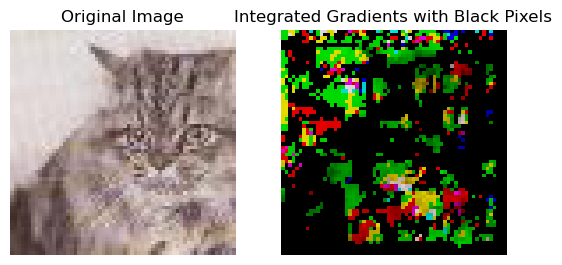

In [36]:
def visualize_integrated_gradients_fixed(integrated_gradients, image):
    # print(torch.norm(integrated_gradients))
    # Convert the image and integrated gradients to numpy arrays
    image_np = image.detach().cpu().numpy()
    integrated_gradients = integrated_gradients.detach().cpu().numpy()

    # Compute the absolute values of the integrated gradients
    # print(np.linalg.norm(integrated_gradients))
    integrated_gradients /= np.linalg.norm(integrated_gradients)
    magnitudes = np.abs(integrated_gradients)
    # print(integrated_gradients)

    max_magnitude = magnitudes.max()
    # Compute a threshold for small magnitudes
    threshold = 0.2 * max_magnitude

    # Create a mask for small magnitudes
    mask = magnitudes < threshold
    print(mask.shape)
    print(mask)
    
    # image = image.transpose(1,2,0)
    gradients_np = integrated_gradients
    gradients_np[mask] = 0

    mask = mask.transpose(1,2,0)
    # overlay_np = image_np.copy()
    # overlay_np[mask] = 0
    # overlay_np /= overlay_np.max()

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image_np)
    axs[0].axis('off')
    axs[0].set_title('Original Image')
    image_np[mask] = 0
    axs[1].imshow(image_np)
    axs[1].axis('off')
    axs[1].set_title('Integrated Gradients with Black Pixels')
    plt.savefig("./Task3.6.png")


    # # Rescale the integrated gradients to the range [0, 255]
    # integrated_gradients = (integrated_gradients * 255).astype(np.uint8)

    # # Convert the integrated gradients to a grayscale image
    # integrated_gradients = np.mean(integrated_gradients, axis=0)
    # print(integrated_gradients)

    # overlay = np.zeros_like(integrated_gradients)
    # overlay[integrated_gradients == np.max(integrated_gradients)] = 255
    
    # # Convert the image to a PyTorch tensor
    # image = torch.from_numpy(image)

    # # Add the white dot overlay to the image
    # overlay = torch.from_numpy(overlay)
    # overlay = overlay.expand_as(image).float() / 255
    # # print(overlay.shape)
    # image = 0.7 * image + 0.3 * overlay

    # # Convert the image to a numpy array and transpose the dimensions
    # # print(image.shape)
    # image = image.permute(0, 2, 3, 1).detach().cpu().numpy()

    # # Show the image with the white dot overlay
    # # print(image[0].astype(np.uint8))
    # plt.imshow(image[0].astype(np.uint8))
    # plt.show()
visualize_integrated_gradients_fixed(integrated_gradients, image)

(224, 224)
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True False  True ...  True  True  True]
 [ True  True False ...  True  True  True]]


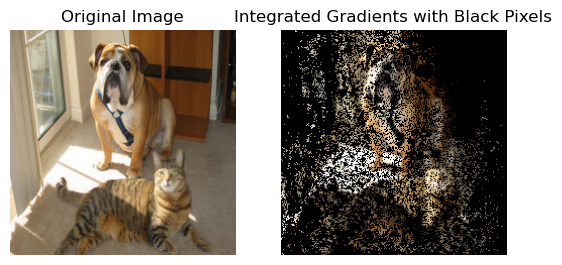

In [113]:
def visualize_integrated_gradients_fixed(integrated_gradients, image):
    # print(torch.norm(integrated_gradients))
    # Convert the image and integrated gradients to numpy arrays
    image_np = image.detach().cpu().numpy()
    integrated_gradients = integrated_gradients.detach().cpu().numpy()

    # Compute the absolute values of the integrated gradients
    # print(np.linalg.norm(integrated_gradients))
    integrated_gradients /= np.linalg.norm(integrated_gradients)
    magnitudes = np.abs(integrated_gradients.mean(axis=0))
    # print(integrated_gradients)

    max_magnitude = magnitudes.max()
    # Compute a threshold for small magnitudes
    threshold = 0.05 * max_magnitude

    # Create a mask for small magnitudes
    mask = magnitudes < threshold
    print(mask.shape)
    print(mask)
    
    # image = image.transpose(1,2,0)

    # gradients_np = integrated_gradients
    # gradients_np[mask] = 0


    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image_np)
    axs[0].axis('off')
    axs[0].set_title('Original Image')
    image_np[mask] = 0
    axs[1].imshow(image_np)
    axs[1].axis('off')
    axs[1].set_title('Integrated Gradients with Black Pixels')
    plt.savefig("./Task3.6.png")

visualize_integrated_gradients_fixed(integrated_gradients, image.permute(1,2,0))

torch.Size([1, 3, 480, 640])
torch.Size([1, 3, 480, 640])
[[[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 ...

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]
  ...
  [1 1 1]
  [1 1 1]
  [1 1 1]]]


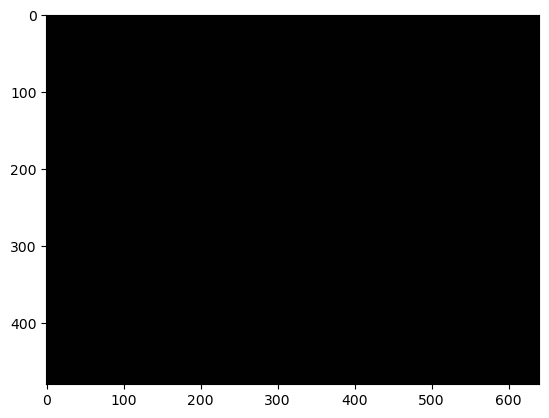

In [35]:
# 没用
def visualize_integrated_gradients(integrated_gradients, image):
    # Normalize the integrated gradients
    integrated_gradients /= torch.norm(integrated_gradients)

    # Convert the image and integrated gradients to numpy arrays
    image = image.detach().cpu().numpy()
    integrated_gradients = integrated_gradients.detach().cpu().numpy()

    # Compute the absolute values of the integrated gradients
    integrated_gradients = np.abs(integrated_gradients)

    # Rescale the integrated gradients to the range [0, 255]
    integrated_gradients = (integrated_gradients * 255).astype(np.uint8)

    # Convert the integrated gradients to a grayscale image
    integrated_gradients = np.mean(integrated_gradients, axis=0)

    # Create a white dot overlay by setting the pixels with the highest integrated gradients to 255
    overlay = np.zeros_like(integrated_gradients)
    overlay[integrated_gradients == np.max(integrated_gradients)] = 255

    # Convert the image to a PyTorch tensor
    image = torch.from_numpy(image)

    # Add the white dot overlay to the image
    overlay = torch.from_numpy(overlay)
    overlay = overlay.expand_as(image).float() / 255
    print(overlay.shape)
    image = 0.7 * image + 0.3 * overlay

    # Convert the image to a numpy array and transpose the dimensions
    print(image.shape)
    image = image.permute(0, 2, 3, 1).detach().cpu().numpy()

    # Show the image with the white dot overlay
    print(image[0].astype(np.uint8))
    plt.imshow(image[0].astype(np.uint8))
    plt.show()
# print(cat_dog.shape)
visualize_integrated_gradients(integrated_gradients, image.unsqueeze(0).permute(0,3,1,2))